# Project Outline

## Contents
 1. Building the Database
 2. Data Analysis
 3. Machine Learning

## Objective
Study the impact congestion pricing would have in New York City

### 1. Building the Database

First, we will import all necessary libraries needed throughout this project

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

### Data Collection
To build our database, we begin by collecting the data. As mentioned in the readme file, this project will study air pollution in NYC and the need for congestion pricing. Since the city's plan for congestion pricing will only be implemented in the central business district (CBD), we only need data from neighborhodos below 60th street in Manhattan. Luckily, NYC's OpenData website has the data we need, and the attached air quality file comes from a query of their data. Lets look at what's in the file. 

In [60]:
df = pd.read_csv('Air_Quality_20241208.csv')
print(df.head())

   Unique ID  Indicator ID                     Name Measure Measure Info  \
0     827047           386               Ozone (O3)    Mean          ppb   
1     825843           375   Nitrogen dioxide (NO2)    Mean          ppb   
2     823346           365  Fine particles (PM 2.5)    Mean       mcg/m3   
3     825870           375   Nitrogen dioxide (NO2)    Mean          ppb   
4     827055           386               Ozone (O3)    Mean          ppb   

  Geo Type Name  Geo Join ID                       Geo Place Name  \
0            CD          102     Greenwich Village and Soho (CD2)   
1            CD          103  Lower East Side and Chinatown (CD3)   
2            CD          102     Greenwich Village and Soho (CD2)   
3         UHF34       306308                      Chelsea-Village   
4         UHF34       306308                      Chelsea-Village   

   Time Period  Start_Date  Data Value  Message  
0  Summer 2022  06/01/2022        30.2      NaN  
1  Summer 2022  06/01/2022  

In [61]:
print(df.isna().sum())

Unique ID            0
Indicator ID         0
Name                 0
Measure              0
Measure Info         0
Geo Type Name        0
Geo Join ID          0
Geo Place Name       0
Time Period          0
Start_Date           0
Data Value           0
Message           1598
dtype: int64


In [62]:
data_types = df.dtypes
print(data_types)

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID         int64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object


### Data Cleaning
At first glance, it seems that this dataset is clean as only the 'Message' column has null values. Now lets dig deeper into what values are being stored to find irregularities we may need to correct like case sensitivity. We will use sets to manually check for nonsencical values in the columns that will matter for the analysis. 


In [63]:
pollutants = set(df['Name'])
measure = set(df['Measure'])
units = set(df['Measure Info'])
time = set(df['Start_Date'])

print(f'Pollutants: {pollutants}\n\nMeasures: {measure}\n\nUnits: {units}\n\nTime: {time}')

Pollutants: {'Annual vehicle miles traveled (cars)', 'Respiratory hospitalizations due to PM2.5 (age 20+)', 'Asthma hospitalizations due to Ozone', 'Cardiovascular hospitalizations due to PM2.5 (age 40+)', 'Outdoor Air Toxics - Formaldehyde', 'Ozone (O3)', 'Nitrogen dioxide (NO2)', 'Asthma emergency departments visits due to Ozone', 'Boiler Emissions- Total PM2.5 Emissions', 'Asthma emergency department visits due to PM2.5', 'Boiler Emissions- Total NOx Emissions', 'Fine particles (PM 2.5)', 'Boiler Emissions- Total SO2 Emissions', 'Deaths due to PM2.5', 'Outdoor Air Toxics - Benzene', 'Annual vehicle miles traveled', 'Cardiac and respiratory deaths due to Ozone', 'Annual vehicle miles traveled (trucks)'}

Measures: {'Annual average concentration', 'Estimated annual rate (under age 18)', 'Million miles', 'Estimated annual rate (age 18+)', 'Number per km2', 'Estimated annual rate', 'Estimated annual rate (age 30+)', 'Mean'}

Units: {'Âµg/m3', 'per 100,000 children', 'number', 'per 100,0

### Building the Database
The output shows us that there are no bad values in the columsn we need, and also gives more information about what data we have. Given this information, let's filter our data to build our database and so we can draw relevant analysis. The three factors we have the most information about, and will be focusing on, are Ozone pollution, Fine Particles aka Particulate Matter (PM), and vehicle miles traveled. 

In [64]:
relevant_indicators = [
    'Ozone (O3)', 'Cardiac and respiratory deaths due to Ozone', 
    'Asthma emergency departments visits due to Ozone', 'Fine particles (PM 2.5)', 
    'Deaths due to PM2.5', 'Asthma emergency department visits due to PM2.5', 
    'Annual vehicle miles traveled', 'Annual vehicle miles traveled (trucks)', 
    'Annual vehicle miles traveled (cars)'
]

# Extract year from Start_Date
df['Year'] = pd.to_datetime(df['Start_Date']).dt.year

# Filter data to include only relevant indicators
filtered_df = df[df['Name'].isin(relevant_indicators)]

# Pivot the DataFrame
pivot_df = filtered_df.pivot_table(
    index=['Geo Place Name', 'Geo Join ID', 'Year'],
    columns='Name',
    values='Data Value',
    aggfunc='first'  # Use 'first' in case of duplicates
).reset_index()

# Reorder columns and add a unique ID
pivot_df = pivot_df[['Geo Place Name', 'Geo Join ID', 'Year'] + relevant_indicators]
pivot_df.insert(0, 'Unique ID', range(1, len(pivot_df) + 1))

# Create SQLite database and save the DataFrame
connection = sqlite3.connect('pollution_data.db')
pivot_df.to_sql('pollution_data', connection, if_exists='replace', index=False)

# Display the database
query = "SELECT * FROM pollution_data"
data = pd.read_sql_query(query, connection)
print(data)

     Unique ID                Geo Place Name  Geo Join ID  Year  Ozone (O3)  \
0            1             Chelsea - Clinton          306  2005         NaN   
1            2             Chelsea - Clinton          306  2008         NaN   
2            3             Chelsea - Clinton          306  2009        21.3   
3            4             Chelsea - Clinton          306  2010        25.6   
4            5             Chelsea - Clinton          306  2011        24.2   
..         ...                           ...          ...   ...         ...   
185        186  Union Square-Lower Manhattan       309310  2018        26.5   
186        187  Union Square-Lower Manhattan       309310  2019        25.4   
187        188  Union Square-Lower Manhattan       309310  2020        28.5   
188        189  Union Square-Lower Manhattan       309310  2021        28.2   
189        190  Union Square-Lower Manhattan       309310  2022        30.9   

     Cardiac and respiratory deaths due to Ozone  \

### 2. Data Analysis and Visualization
Now that we have completed our database, let's query it and create graphs to study air pollution in Midtown and Lower Manhattan. 

In [ ]:
# Query to get relevant data
query = """
SELECT 
    "Ozone (O3)" AS ozone_ppb, 
    "Fine particles (PM 2.5)" AS fine_pm25,
    "Cardiac and respiratory deaths due to Ozone" AS ozone_deaths, 
    "Deaths due to PM2.5" AS pm25_deaths
FROM pollution_data
WHERE "Ozone (O3)" IS NOT NULL 
  AND "Fine particles (PM 2.5)" IS NOT NULL
  AND "Cardiac and respiratory deaths due to Ozone" IS NOT NULL
  AND "Deaths due to PM2.5" IS NOT NULL;
"""

# Load data into a Pandas DataFrame
df = pd.read_sql_query(query, connection)

# Visualize relationships using matplotlib
# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Plot Ozone Concentration vs. Deaths due to Ozone
plt.subplot(1, 2, 1)
plt.scatter(df['ozone_ppb'], df['ozone_deaths'], color='red')
plt.title('Ozone Concentration vs. Deaths due to Ozone')
plt.xlabel('Ozone Concentration (ppb)')
plt.ylabel('Deaths due to Ozone (per 100,000)')

# Plot Fine Particles PM 2.5 vs. Deaths due to PM2.5
plt.subplot(1, 2, 2)
plt.scatter(df['fine_pm25'], df['pm25_deaths'], color='orange')
plt.title('PM2.5 Concentration vs. Deaths due to PM2.5')
plt.xlabel('PM2.5 (mcg/m3)')
plt.ylabel('Deaths due to PM2.5 (per 100,000)')

# Improve layout and show the plot
plt.tight_layout()
plt.show()


When reading the scatterplot for fine particles (PM2.5), we see that there is a general positive coorelation between increased fine particle concentration, but there is one outlier that significantly deviates. Upon further analysis, this point represents the Lower East Side neighborhood, which has a large concentration of public housing. These apartments are located close to FDR Dr (a major 6 lane freeway in Manhattan) and the Williamsburg Bridge (which carries a total of 8 lanes). The economically disadvantaged people that live in public housing often lack adequate healthcare, which can also explain the strong deviation from the norm in deaths due to particulate matter.

When reading the scatterplot for ozone, there are two points that deviate from the pattern. One of the lower points represents the Greenwich Village-SoHo area. These two are some of the most wealthiest neighborhoods in the city, and neither contain any freeways or bridges. It is most plausible that the socioeconomic status of the residents of this area, combined with its urban planning is what has lead to a  noticeably lower death rate from ozone. The residents of these neighborhoods were able to successfully lobby against freeway expansion when the Interstate Highways System was being built, which shows the intersectionality between socioeconomic status and health.


In [ ]:
# Query data to get relevant columns
query = """
SELECT 
    "Year" AS Year,
    "Ozone (O3)" AS ozone,
    "Fine particles (PM 2.5)" AS pm25
FROM pollution_data
WHERE "Ozone (O3)" IS NOT NULL 
  AND "Fine particles (PM 2.5)" IS NOT NULL
  AND "Year" IS NOT NULL;
"""

# Load data into a Pandas DataFrame
df = pd.read_sql_query(query, connection)

# Visualize trends with a scatter plot using matplotlib
plt.figure(figsize=(12, 6))

# Scatter plot for Ozone concentrations
plt.scatter(df['Year'], df['ozone'], color='green', alpha=0.7, label='Ozone (ppb)', marker='o')

# Scatter plot for PM2.5 concentrations
plt.scatter(df['Year'], df['pm25'], color='blue', alpha=0.7, label='PM2.5 (mcg/m3)', marker='o')

# Plot details
plt.title('Ozone and Fine Particles Concentrations Over Time')
plt.xlabel('Year')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

This data shows us a few interesting trends. With ozone pollution, we see that it has generally increased over time with the least polluted neighborhoods in 2022 having more ozone pollution than the most ozone polluted in 2009. We also see a general decrease in the stratification of ozone pollution data by year, signifying that neighborhoods in the CBD, even more residential ones, are as congested as ever. 

But wait... how has particulate matter pollution decreased? To answer this we have to dig into the science of these chemicals. Ozone pollution happens when various diffirent pollutants react with sunlight, particularly under hotter weather conditions, and create ozone at the ground level. PM2.5 are just very tiny particles that are a byproduct of burning gasoline/disel. The EPA has been tightening their regulations when it comes to vehicle emissions, particularly when it comes to particulate matter. Since ozone production is a secondary product, it is much harder to regulate as it isn't directly emitted by vehicles, not to mention that global warming is creating more favorable conditions for ozone pollution. 

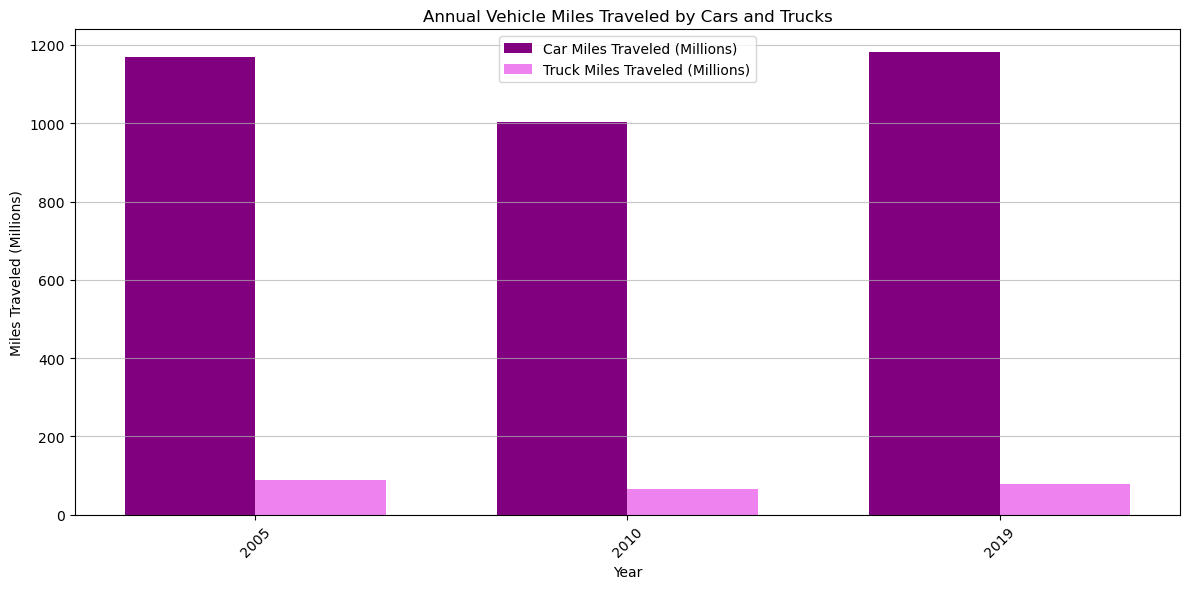

In [67]:
# Query the data with aggregation
query = """
SELECT 
    "Year" AS Year,
    SUM("Annual vehicle miles traveled (cars)") AS car_miles,
    SUM("Annual vehicle miles traveled (trucks)") AS truck_miles
FROM pollution_data
WHERE "Annual vehicle miles traveled (cars)" IS NOT NULL
  AND "Annual vehicle miles traveled (trucks)" IS NOT NULL
  AND "Year" IS NOT NULL
GROUP BY "Year"
ORDER BY Year;
"""

# Load data into a Pandas DataFrame
df = pd.read_sql_query(query, connection)

# Visualize with a grouped bar chart
# Set the positions and width for bars
years = df['Year']
car_miles = df['car_miles']
truck_miles = df['truck_miles']
x = np.arange(len(years))  # Positions for groups
width = 0.35  # Width of bars

# Create a bar chart
plt.figure(figsize=(12, 6))

# Plot Car Miles
plt.bar(x - width/2, car_miles, width, label='Car Miles Traveled (Millions)', color='purple')

# Plot Truck Miles
plt.bar(x + width/2, truck_miles, width, label='Truck Miles Traveled (Millions)', color='violet')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Miles Traveled (Millions)')
plt.title('Annual Vehicle Miles Traveled by Cars and Trucks')
plt.xticks(x, years, rotation=45)  # Use years as x-axis labels
plt.legend()

# Displaying the histogram
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see, there is no significant change in the vehicle miles traveled in the CBD except for the dip in 2010 for car miles traveled. This shows that the roads in this part of the city have reached peak capacity, and they obviously cannot be widened given the state of development in the area. But what does this mean for New Yorkers? When roads have reacher their 'maximum capacity' per se, it makes it difficult for emergency response vehicles to navigate through traffic as there is little room for all the other vehicles to move over. Such congested roads also decrease the quality of life for residents from the constant pollution, honking, and other noise. 

Singapore was the first city/country to implement congestion pricing and many European cities have followed suit. Congestion pricing is used as a tool to reduce traffic in CBDs by charging entering vehicles a fee (toll) to access the roads. This has been a proven method to create safer and quieter streets, increase sustainable funding for public transit as there will always be a demand to drive in the CBD, and secondary effects like ease of travel for more eco friendly options such as buses and bikes.  

### 3. Machine Learning
For this part, we will use linear regression to predict the impact of congestion pricing. According to NYC's congestion pricing plan, the city expects to see a 5% reduction in vehicle miles traveled in the CBD if the current plan is implemented. We will be predicting the impact a 5% and 10% reduction in vehicle miles traveled will have on deaths from ozone and PM2.5. Then we will graph the results to visualize the impact. 

In [56]:
query = """
SELECT 
    "Annual vehicle miles traveled" AS vehicle_miles,
    "Cardiac and respiratory deaths due to Ozone" AS deaths_ozone,
    "Deaths due to PM2.5" AS deaths_pm25
FROM pollution_data
WHERE "Annual vehicle miles traveled" IS NOT NULL
  AND "Cardiac and respiratory deaths due to Ozone" IS NOT NULL
  AND "Deaths due to PM2.5" IS NOT NULL;
"""

df = pd.read_sql_query(query, connection)

# Check the data
print(df.head())

# Features (X) and targets (y)
X = df[['vehicle_miles']]
y_ozone = df['deaths_ozone']
y_pm25 = df['deaths_pm25']

# Split data into training and testing sets
X_train, X_test, y_train_ozone, y_test_ozone = train_test_split(X, y_ozone, test_size=0.2, random_state=42)
_, _, y_train_pm25, y_test_pm25 = train_test_split(X, y_pm25, test_size=0.2, random_state=42)

# Train models
model_ozone = LinearRegression()
model_pm25 = LinearRegression()

model_ozone.fit(X_train, y_train_ozone)
model_pm25.fit(X_train, y_train_pm25)

# Predictions for the test set
y_pred_ozone = model_ozone.predict(X_test)
y_pred_pm25 = model_pm25.predict(X_test)

# Simulate reductions
reductions = [0.05, 0.10]
predictions = {}

for reduction in reductions:
    X_reduced = X * (1 - reduction)  # Reduce vehicle miles
    predictions[f"{int(reduction * 100)}% reduction"] = {
        'deaths_ozone': model_ozone.predict(X_reduced),
        'deaths_pm25': model_pm25.predict(X_reduced),
    }

# Calculate metrics
mse_ozone = mean_squared_error(y_test_ozone, y_pred_ozone)
mse_pm25 = mean_squared_error(y_test_pm25, y_pred_pm25)

print(f"Ozone Model - MSE: {mse_ozone:.4f}")
print(f"PM2.5 Model - MSE: {mse_pm25:.4f}")


   vehicle_miles  deaths_ozone  deaths_pm25
0          126.0           4.0         57.5
1          185.6           3.2         52.7
2          132.6           3.1         45.4
3           95.4           3.8         59.5
4          123.8           3.9         66.9
Ozone Model - MSE: 0.0114
PM2.5 Model - MSE: 79.3095


In [ ]:
# Visualize Ozone Deaths
plt.figure(figsize=(10, 6))
years = list(range(len(df)))  # Create a mock timeline for simplicity

for reduction, values in predictions.items():
    plt.plot(
        years, values['deaths_ozone'],
        label=f'Ozone Deaths ({reduction})', linestyle='--'
    )

# Actual data for reference
plt.plot(years, y_ozone.values, label='Actual Ozone Deaths', color='blue')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Deaths per 100,000')
plt.title('Predicted Ozone Deaths under Congestion Pricing Reductions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize PM2.5 Deaths
plt.figure(figsize=(10, 6))

for reduction, values in predictions.items():
    plt.plot(
        years, values['deaths_pm25'],
        label=f'PM2.5 Deaths ({reduction})', linestyle=':'
    )

# Actual data for reference
plt.plot(years, y_pm25.values, label='Actual PM2.5 Deaths', color='orange')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Deaths per 100,000')
plt.title('Predicted PM2.5 Deaths under Congestion Pricing Reductions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


From the graph that shows the prediction for the impact congestion pricing will have, we can see that at the end of the 4 year period, there will be a reduced death rate when compared to if no congestion pricing was implemented. However, the difference between death rates when compared to the beginning of the four year period is minimal. This means that while congestion pricing will have an overall positive impact, the toll is not a strong enough deterrent to reduce ozone pollution levels. It is important to note that congestion pricing would generate about $490M per year, which would contribute significantly to public transportation and indirectly reduce vehicle miles traveled, which this model does not take into account. The deaths from PM2.5 also shows a similar outcome. 